### Introduction

In topic modeling with gensim, we followed a structured workflow to build an insightful topic model based on the Latent Dirichlet Allocation (LDA) algorithm.

### Overview

- Import Dataset
- Tokenize Sentences and Clean
- Build the Bigram, Trigram Models and Lemmatize
- Build the Topic Model
- What is the Dominant topic and its percentage contribution in each document?
- The most representative sentence for each topic
- Frequency Distribution of Word Counts in Documents
- Word Clouds of Top N Keywords in Each Topic
- Word Counts of Topic Keywords
- Sentence Chart Colored by Topic
- What are the most discussed topics in the documents?
- t-SNE Clustering Chart
- pyLDAVis

In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend([
    'from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_',
    'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some',
    'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack',
    'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even',
    'also', 'may', 'take', 'come'
])

%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.ERROR)

### Import Dataset

In [2]:
# Import Dataset
df = pd.read_json(
    'https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json'
)
df = df.loc[df.target_names.isin([
    'soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast',
    'rec.motorcycles'
]), :]
print(df.shape)  #> (2361, 3)
df.head()

(2361, 3)


,content,target,target_names
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
21,From: leunggm@odin.control.utoronto.ca (Gary L...,10,rec.sport.hockey
28,From: jonh@david.wheaton.edu (Jonathan Hayward...,15,soc.religion.christian
33,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,17,talk.politics.mideast
35,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey


### Tokenize Sentences and Clean

Removing the emails, new line characters, single quotes and finally split the sentence into a list of words using gensim’s `simple_preprocess()`. Setting the `deacc=True` option removes punctuations.

In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield (sent)


# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

### Build the Bigram, Trigram Models and Lemmatize

In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(
    data_words, min_count=5, threshold=100)  # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


# !python3 -m spacy download en  # run in terminal once
def process_words(texts,
                  stop_words=stop_words,
                  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[
        word for word in simple_preprocess(str(doc)) if word not in stop_words
    ] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[
        word for word in simple_preprocess(str(doc)) if word not in stop_words
    ] for doc in texts_out]
    return texts_out


data_ready = process_words(data_words)  # processed Text Data!

### Build the Topic Model

In [5]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=4,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=10,
                                            passes=10,
                                            alpha='symmetric',
                                            iterations=100,
                                            per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.014*"israeli" + 0.012*"armenian" + 0.011*"greek" + 0.010*"kill" + '
  '0.009*"turk" + 0.009*"war" + 0.009*"people" + 0.008*"government" + '
  '0.008*"attack" + 0.007*"turkish"'),
 (1,
  '0.026*"team" + 0.019*"game" + 0.016*"hockey" + 0.012*"play" + 0.010*"win" + '
  '0.010*"year" + 0.010*"player" + 0.009*"nhl" + 0.007*"playoff" + '
  '0.007*"wing"'),
 (2,
  '0.012*"god" + 0.011*"people" + 0.009*"write" + 0.008*"israel" + '
  '0.007*"believe" + 0.007*"christian" + 0.006*"reason" + 0.006*"organization" '
  '+ 0.005*"evidence" + 0.005*"give"'),
 (3,
  '0.014*"organization" + 0.014*"write" + 0.010*"article" + 0.008*"bike" + '
  '0.007*"host" + 0.007*"time" + 0.006*"well" + 0.005*"new" + '
  '0.004*"california" + 0.004*"look"')]


### What is the Dominant topic and its percentage contribution in each document

In [6]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series(
                    [int(topic_num),
                     round(prop_topic, 4), topic_keywords]),
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = [
        'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'
    ]

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return (sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model,
                                                  corpus=corpus,
                                                  texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text'
]
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9103,"organization, write, article, bike, host, time...","[irwin, arnstein, recommendation, summary, wor..."
1,1,1.0,0.7182,"team, game, hockey, play, win, year, player, n...","[gary, leung, organization, university, toront..."
2,2,2.0,0.6801,"god, people, write, israel, believe, christian...","[jonathan, hayward, pantheism, organization, w..."
3,3,0.0,0.4328,"israeli, armenian, greek, kill, turk, war, peo...","[nntp_poste, reply, organization, article, jos..."
4,4,3.0,0.5889,"organization, write, article, bike, host, time...","[goalie_mask, nntp_poste, ists_ca, organizatio..."
5,5,3.0,0.6212,"organization, write, article, bike, host, time...","[joe, ehrlich, bmw_moa_member, read, organizat..."
6,6,3.0,0.7723,"organization, write, article, bike, host, time...","[require, organization, nec_system, article, t..."
7,7,3.0,0.7632,"organization, write, article, bike, host, time...","[speedy_mercer, look, movie, bike, organizatio..."
8,8,2.0,0.9771,"god, people, write, israel, believe, christian...","[organization, florida_state, university, foll..."
9,9,0.0,0.6571,"israeli, armenian, greek, kill, turk, war, peo...","[serdar_argic, day, night, armenian, round, ma..."


### The most representative sentence for each topic

In [7]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([
        sent_topics_sorteddf_mallet,
        grp.sort_values(['Perc_Contribution'], ascending=False).head(1)
    ],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = [
    'Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"
]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9966,"israeli, armenian, greek, kill, turk, war, people, government, attack, turkish","[serdar_argic, armenian, genocide, muslim, people, article, zuma, reply, article, write, alah, a..."
1,1.0,0.9984,"team, game, hockey, play, win, year, player, nhl, playoff, wing","[nhl, game, play, sat, april, organization, university, philadelphia, first, period, philadelphi..."
2,2.0,0.9963,"god, people, write, israel, believe, christian, reason, organization, evidence, give","[virgilio_dean, velasco_jr, arrogance, christian, organization, usa, write, write, write, truth,..."
3,3.0,0.9903,"organization, write, article, bike, host, time, well, new, california, look","[chris_behanna, flash, keyword, flash, organization, nec_system, article, write, bike, hazard, l..."


### Frequency Distribution of Word Counts in Documents

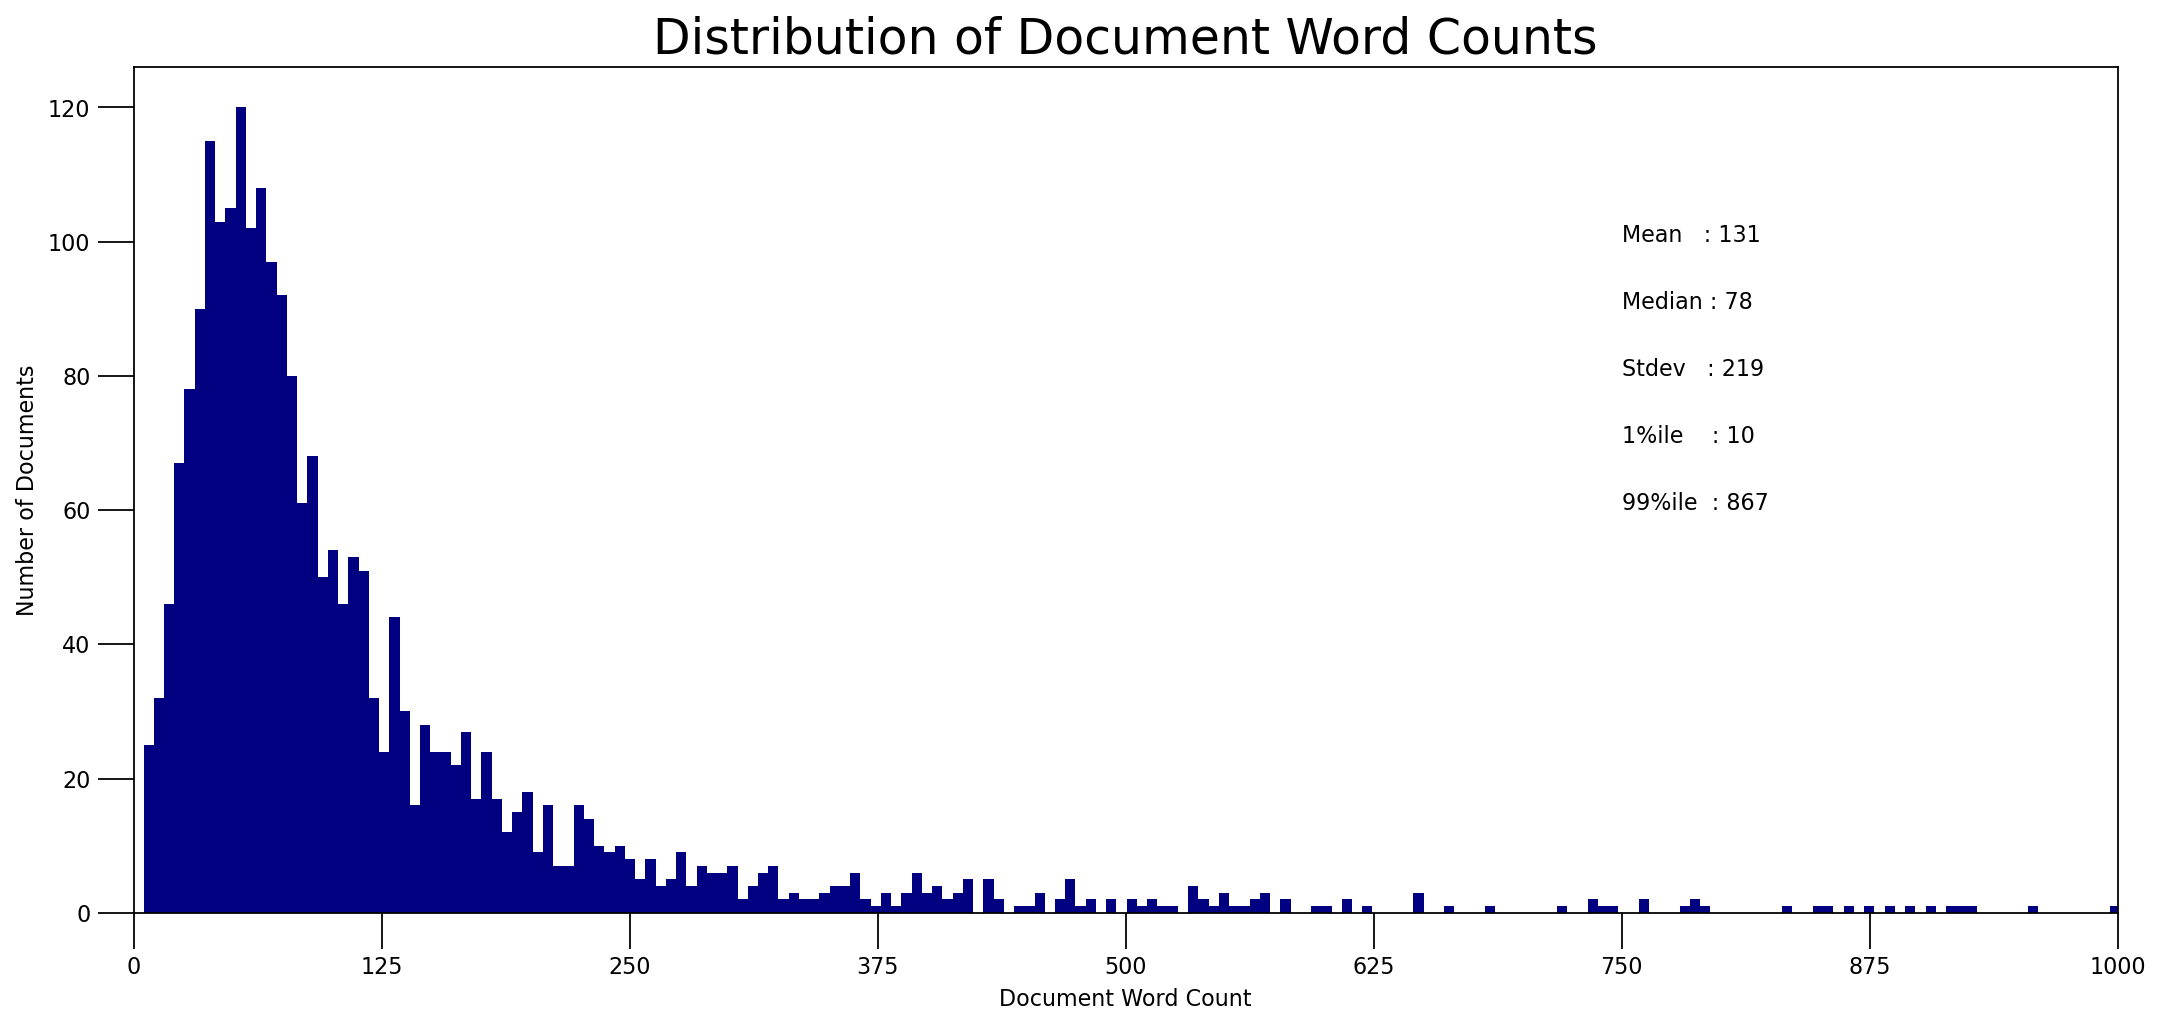

In [8]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16, 7), dpi=160)
plt.hist(doc_lens, bins=1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750, 90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750, 80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750, 70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750, 60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000),
              ylabel='Number of Documents',
              xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0, 1000, 9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

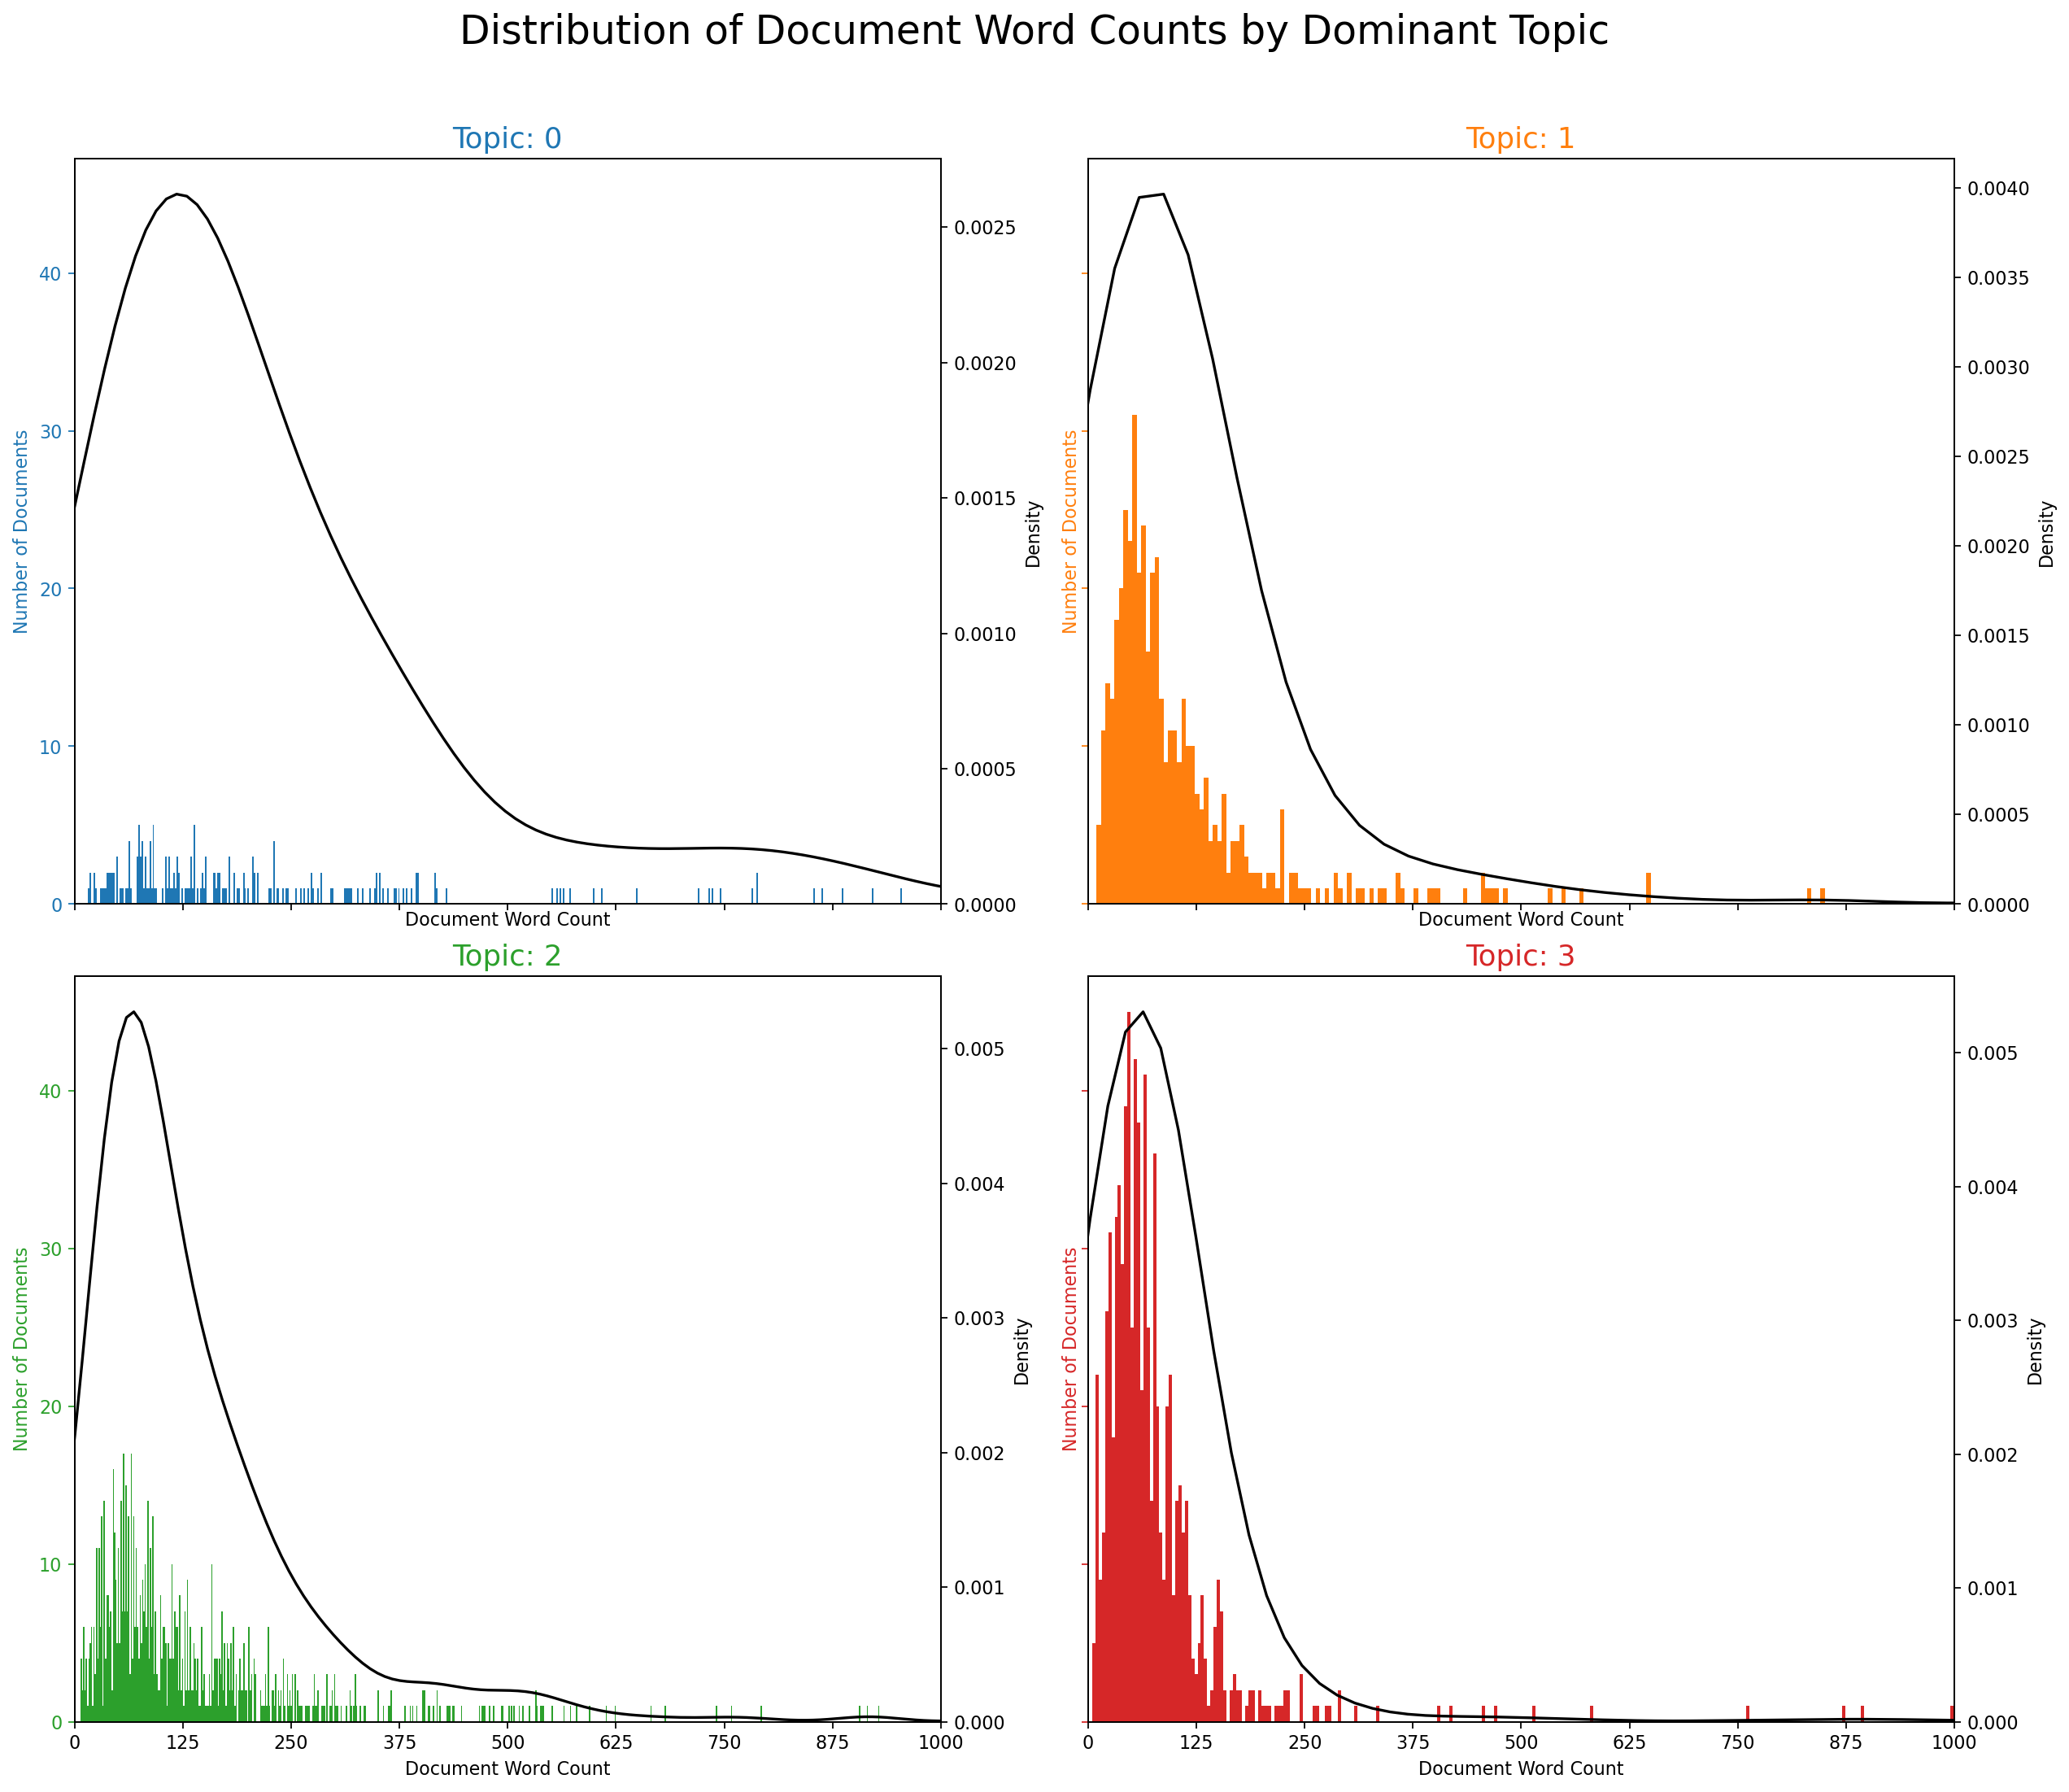

In [9]:
import seaborn as sns
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()
        ]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,
                         2,
                         figsize=(16, 14),
                         dpi=160,
                         sharex=True,
                         sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[
        df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins=1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: ' + str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0, 1000, 9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic',
             fontsize=22)
plt.show()

### Word Clouds of Top N Keywords in Each Topic

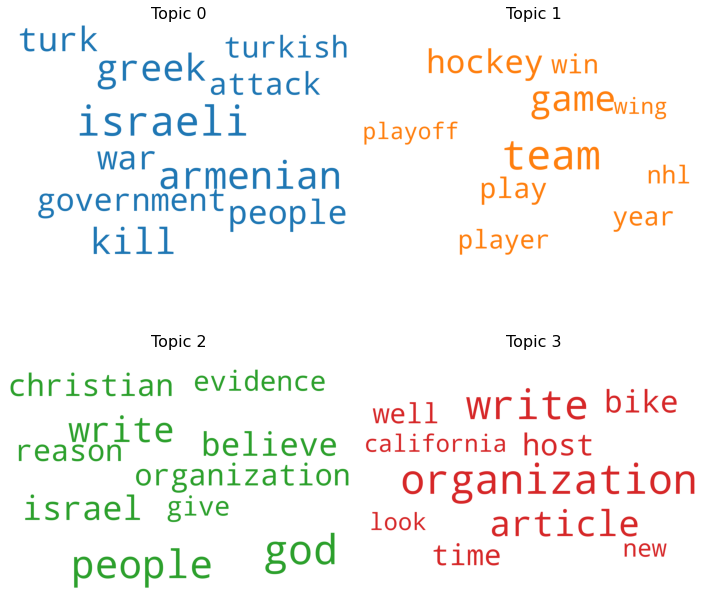

In [10]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()
        ]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()